In [1]:


from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import cv2
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision import models
!pip install scikit-learn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
!pip install seaborn
!pip install timm
import timm
from timm.loss import LabelSmoothingCrossEntropy
import torch.nn as nn
import torch.optim as optim
import copy
from tqdm import tqdm
import time
from torch.cuda.amp import GradScaler, autocast

In [6]:
models = timm.list_models()
for model in models:
    print(model)


bat_resnext26ts
beit_base_patch16_224
beit_base_patch16_384
beit_large_patch16_224
beit_large_patch16_384
beit_large_patch16_512
beitv2_base_patch16_224
beitv2_large_patch16_224
botnet26t_256
botnet50ts_256
caformer_b36
caformer_m36
caformer_s18
caformer_s36
cait_m36_384
cait_m48_448
cait_s24_224
cait_s24_384
cait_s36_384
cait_xs24_384
cait_xxs24_224
cait_xxs24_384
cait_xxs36_224
cait_xxs36_384
coat_lite_medium
coat_lite_medium_384
coat_lite_mini
coat_lite_small
coat_lite_tiny
coat_mini
coat_small
coat_tiny
coatnet_0_224
coatnet_0_rw_224
coatnet_1_224
coatnet_1_rw_224
coatnet_2_224
coatnet_2_rw_224
coatnet_3_224
coatnet_3_rw_224
coatnet_4_224
coatnet_5_224
coatnet_bn_0_rw_224
coatnet_nano_cc_224
coatnet_nano_rw_224
coatnet_pico_rw_224
coatnet_rmlp_0_rw_224
coatnet_rmlp_1_rw2_224
coatnet_rmlp_1_rw_224
coatnet_rmlp_2_rw_224
coatnet_rmlp_2_rw_384
coatnet_rmlp_3_rw_224
coatnet_rmlp_nano_rw_224
coatnext_nano_rw_224
convformer_b36
convformer_m36
convformer_s18
convformer_s36
convit_base
conv

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

def load_data(directory, input_shape):
    x = []
    y = []
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                image = cv2.imread(file_path)
                image = cv2.resize(image, (input_shape[1], input_shape[0]))
                x.append(image)
                y.append(class_name)
    x = np.array(x)
    y = np.array(y)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    return x, y_encoded, label_encoder.classes_

input_shape = (384, 384, 3)
train_dir = '/content/drive/MyDrive/Chiro10/train_512'
test_dir = '/content/drive/MyDrive/Chiro10/test_512'
val_dir = '/content/drive/MyDrive/Chiro10/val_512'

x_train, y_train, classes = load_data(train_dir, input_shape)
x_test, y_test, _ = load_data(test_dir, input_shape)
x_val, y_val, _ = load_data(val_dir, input_shape)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((384, 384)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])



train_dataset = CustomDataset(x_train, y_train, transform=transform)
test_dataset = CustomDataset(x_test, y_test, transform=transform)
val_dataset = CustomDataset(x_val, y_val, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

dataloaders = {
    "train": train_dataloader,
    "val": val_dataloader
}

dataset_sizes = {
    "train": len(train_dataset),
    "val": len(val_dataset)
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#vit_base_patch16_224 64 32 32
model = timm.create_model('deit3_tiny_patch16_384', pretrained=False)
model.head = nn.Linear(model.head.in_features, len(classes))
model = model.to(device)

criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

def train_model(model, criterion, optimizer, scheduler, num_epochs=100):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model

def evaluate_model(model, criterion, dataloader):
    model.eval()  # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format('test', epoch_loss, epoch_acc))



model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=100)
evaluate_model(model, criterion, test_dataloader)
torch.save(model.state_dict(), '/content/drive/MyDrive/deit3_small_patch16_224.pth')


x_train shape: (923, 384, 384, 3) - y_train shape: (923,)
x_test shape: (554, 384, 384, 3) - y_test shape: (554,)
x_val shape: (369, 384, 384, 3) - y_val shape: (369,)
Epoch 0/99
----------


100%|██████████| 15/15 [00:41<00:00,  2.74s/it]


train Loss: 2.8489 Acc: 0.1127


100%|██████████| 24/24 [00:04<00:00,  5.17it/s]


val Loss: 2.2483 Acc: 0.2087

Epoch 1/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


train Loss: 2.1939 Acc: 0.1993


100%|██████████| 24/24 [00:04<00:00,  5.04it/s]


val Loss: 2.1038 Acc: 0.2114

Epoch 2/99
----------


100%|██████████| 15/15 [00:39<00:00,  2.62s/it]


train Loss: 2.0282 Acc: 0.2644


100%|██████████| 24/24 [00:04<00:00,  5.09it/s]


val Loss: 2.0030 Acc: 0.2412

Epoch 3/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


train Loss: 1.8537 Acc: 0.3521


100%|██████████| 24/24 [00:04<00:00,  4.96it/s]


val Loss: 1.8282 Acc: 0.3496

Epoch 4/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.50s/it]


train Loss: 1.7247 Acc: 0.4030


100%|██████████| 24/24 [00:04<00:00,  5.05it/s]


val Loss: 1.7200 Acc: 0.4038

Epoch 5/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


train Loss: 1.6484 Acc: 0.4355


100%|██████████| 24/24 [00:04<00:00,  5.04it/s]


val Loss: 1.5834 Acc: 0.5203

Epoch 6/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


train Loss: 1.8756 Acc: 0.3640


100%|██████████| 24/24 [00:04<00:00,  4.97it/s]


val Loss: 1.7577 Acc: 0.4092

Epoch 7/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


train Loss: 1.7561 Acc: 0.3976


100%|██████████| 24/24 [00:04<00:00,  5.06it/s]


val Loss: 1.7070 Acc: 0.4444

Epoch 8/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


train Loss: 1.6446 Acc: 0.4485


100%|██████████| 24/24 [00:04<00:00,  5.05it/s]


val Loss: 1.5484 Acc: 0.4986

Epoch 9/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.50s/it]


train Loss: 1.4653 Acc: 0.5536


100%|██████████| 24/24 [00:04<00:00,  5.01it/s]


val Loss: 1.3884 Acc: 0.5908

Epoch 10/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


train Loss: 1.3770 Acc: 0.5818


100%|██████████| 24/24 [00:04<00:00,  4.96it/s]


val Loss: 1.3308 Acc: 0.6287

Epoch 11/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


train Loss: 1.3629 Acc: 0.6078


100%|██████████| 24/24 [00:04<00:00,  4.87it/s]


val Loss: 1.4547 Acc: 0.5176

Epoch 12/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.53s/it]


train Loss: 1.3301 Acc: 0.6241


100%|██████████| 24/24 [00:05<00:00,  4.75it/s]


val Loss: 1.4132 Acc: 0.5881

Epoch 13/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


train Loss: 1.3124 Acc: 0.6208


100%|██████████| 24/24 [00:05<00:00,  4.74it/s]


val Loss: 1.3442 Acc: 0.5989

Epoch 14/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.50s/it]


train Loss: 1.2517 Acc: 0.6566


100%|██████████| 24/24 [00:05<00:00,  4.73it/s]


val Loss: 1.2981 Acc: 0.5827

Epoch 15/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


train Loss: 1.1919 Acc: 0.6869


100%|██████████| 24/24 [00:05<00:00,  4.75it/s]


val Loss: 1.1776 Acc: 0.6829

Epoch 16/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


train Loss: 1.1648 Acc: 0.6923


100%|██████████| 24/24 [00:05<00:00,  4.79it/s]


val Loss: 1.2217 Acc: 0.6694

Epoch 17/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


train Loss: 1.1548 Acc: 0.6891


100%|██████████| 24/24 [00:04<00:00,  4.87it/s]


val Loss: 1.1601 Acc: 0.6965

Epoch 18/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.53s/it]


train Loss: 1.0871 Acc: 0.7172


100%|██████████| 24/24 [00:04<00:00,  4.99it/s]


val Loss: 1.1307 Acc: 0.6965

Epoch 19/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


train Loss: 1.0880 Acc: 0.7313


100%|██████████| 24/24 [00:04<00:00,  4.99it/s]


val Loss: 1.1722 Acc: 0.7046

Epoch 20/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


train Loss: 1.0818 Acc: 0.7291


100%|██████████| 24/24 [00:04<00:00,  5.01it/s]


val Loss: 1.0563 Acc: 0.7507

Epoch 21/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


train Loss: 0.9985 Acc: 0.7811


100%|██████████| 24/24 [00:04<00:00,  4.98it/s]


val Loss: 1.0431 Acc: 0.7832

Epoch 22/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


train Loss: 1.0035 Acc: 0.7703


100%|██████████| 24/24 [00:04<00:00,  5.02it/s]


val Loss: 1.0562 Acc: 0.7317

Epoch 23/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


train Loss: 1.0013 Acc: 0.7746


100%|██████████| 24/24 [00:04<00:00,  5.00it/s]


val Loss: 1.2088 Acc: 0.6694

Epoch 24/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


train Loss: 1.0658 Acc: 0.7541


100%|██████████| 24/24 [00:04<00:00,  5.00it/s]


val Loss: 1.0749 Acc: 0.7263

Epoch 25/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.53s/it]


train Loss: 0.9591 Acc: 0.7844


100%|██████████| 24/24 [00:04<00:00,  4.98it/s]


val Loss: 1.0208 Acc: 0.7425

Epoch 26/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


train Loss: 0.9016 Acc: 0.8234


100%|██████████| 24/24 [00:04<00:00,  4.97it/s]


val Loss: 0.8952 Acc: 0.8428

Epoch 27/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


train Loss: 0.9351 Acc: 0.8223


100%|██████████| 24/24 [00:04<00:00,  4.94it/s]


val Loss: 0.9386 Acc: 0.8049

Epoch 28/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


train Loss: 0.8758 Acc: 0.8505


100%|██████████| 24/24 [00:04<00:00,  4.85it/s]


val Loss: 0.9650 Acc: 0.8184

Epoch 29/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


train Loss: 0.9082 Acc: 0.8212


100%|██████████| 24/24 [00:04<00:00,  4.83it/s]


val Loss: 0.8900 Acc: 0.8482

Epoch 30/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.53s/it]


train Loss: 0.8363 Acc: 0.8711


100%|██████████| 24/24 [00:04<00:00,  4.97it/s]


val Loss: 0.8576 Acc: 0.8564

Epoch 31/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


train Loss: 0.8352 Acc: 0.8678


100%|██████████| 24/24 [00:04<00:00,  4.91it/s]


val Loss: 0.9453 Acc: 0.8374

Epoch 32/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


train Loss: 0.8869 Acc: 0.8321


100%|██████████| 24/24 [00:04<00:00,  4.87it/s]


val Loss: 0.8912 Acc: 0.8374

Epoch 33/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


train Loss: 0.8461 Acc: 0.8581


100%|██████████| 24/24 [00:05<00:00,  4.74it/s]


val Loss: 0.8590 Acc: 0.8591

Epoch 34/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.50s/it]


train Loss: 0.7609 Acc: 0.9036


100%|██████████| 24/24 [00:05<00:00,  4.69it/s]


val Loss: 0.8267 Acc: 0.8564

Epoch 35/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


train Loss: 0.7473 Acc: 0.9003


100%|██████████| 24/24 [00:05<00:00,  4.69it/s]


val Loss: 0.8600 Acc: 0.8347

Epoch 36/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


train Loss: 0.7669 Acc: 0.8927


100%|██████████| 24/24 [00:05<00:00,  4.70it/s]


val Loss: 0.8377 Acc: 0.8509

Epoch 37/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


train Loss: 0.7315 Acc: 0.9166


100%|██████████| 24/24 [00:05<00:00,  4.78it/s]


val Loss: 0.8395 Acc: 0.8591

Epoch 38/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.50s/it]


train Loss: 0.7442 Acc: 0.8992


100%|██████████| 24/24 [00:04<00:00,  4.83it/s]


val Loss: 0.8529 Acc: 0.8564

Epoch 39/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


train Loss: 0.7497 Acc: 0.9025


100%|██████████| 24/24 [00:04<00:00,  4.90it/s]


val Loss: 0.8123 Acc: 0.8699

Epoch 40/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


train Loss: 0.7823 Acc: 0.8754


100%|██████████| 24/24 [00:04<00:00,  4.97it/s]


val Loss: 0.9637 Acc: 0.8022

Epoch 41/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


train Loss: 0.8268 Acc: 0.8462


100%|██████████| 24/24 [00:04<00:00,  5.01it/s]


val Loss: 0.8628 Acc: 0.8428

Epoch 42/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.53s/it]


train Loss: 0.7681 Acc: 0.8884


100%|██████████| 24/24 [00:04<00:00,  5.00it/s]


val Loss: 0.8249 Acc: 0.8537

Epoch 43/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


train Loss: 0.7515 Acc: 0.9068


100%|██████████| 24/24 [00:04<00:00,  5.00it/s]


val Loss: 0.7794 Acc: 0.8862

Epoch 44/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


train Loss: 0.7201 Acc: 0.9068


100%|██████████| 24/24 [00:04<00:00,  5.03it/s]


val Loss: 0.8362 Acc: 0.8645

Epoch 45/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


train Loss: 0.7193 Acc: 0.9112


100%|██████████| 24/24 [00:04<00:00,  5.00it/s]


val Loss: 0.8165 Acc: 0.8780

Epoch 46/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


train Loss: 0.6867 Acc: 0.9263


100%|██████████| 24/24 [00:04<00:00,  4.99it/s]


val Loss: 0.8269 Acc: 0.8780

Epoch 47/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


train Loss: 0.7341 Acc: 0.9014


100%|██████████| 24/24 [00:04<00:00,  4.99it/s]


val Loss: 0.7854 Acc: 0.8808

Epoch 48/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.54s/it]


train Loss: 0.6992 Acc: 0.9177


100%|██████████| 24/24 [00:04<00:00,  5.03it/s]


val Loss: 0.7464 Acc: 0.9024

Epoch 49/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


train Loss: 0.6764 Acc: 0.9350


100%|██████████| 24/24 [00:04<00:00,  4.98it/s]


val Loss: 0.7857 Acc: 0.8889

Epoch 50/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


train Loss: 0.7260 Acc: 0.9101


100%|██████████| 24/24 [00:04<00:00,  4.95it/s]


val Loss: 0.7971 Acc: 0.8916

Epoch 51/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


train Loss: 0.6743 Acc: 0.9220


100%|██████████| 24/24 [00:04<00:00,  5.01it/s]


val Loss: 0.8340 Acc: 0.8591

Epoch 52/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.53s/it]


train Loss: 0.6847 Acc: 0.9274


100%|██████████| 24/24 [00:04<00:00,  4.93it/s]


val Loss: 0.7796 Acc: 0.8808

Epoch 53/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


train Loss: 0.6789 Acc: 0.9252


100%|██████████| 24/24 [00:04<00:00,  4.84it/s]


val Loss: 0.8113 Acc: 0.8780

Epoch 54/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


train Loss: 0.6548 Acc: 0.9372


100%|██████████| 24/24 [00:04<00:00,  4.80it/s]


val Loss: 0.7203 Acc: 0.9133

Epoch 55/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


train Loss: 0.6859 Acc: 0.9231


100%|██████████| 24/24 [00:05<00:00,  4.75it/s]


val Loss: 0.7346 Acc: 0.8943

Epoch 56/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


train Loss: 0.6671 Acc: 0.9274


100%|██████████| 24/24 [00:05<00:00,  4.67it/s]


val Loss: 0.7906 Acc: 0.8726

Epoch 57/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


train Loss: 0.6316 Acc: 0.9502


100%|██████████| 24/24 [00:05<00:00,  4.65it/s]


val Loss: 0.7822 Acc: 0.8726

Epoch 58/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


train Loss: 0.6345 Acc: 0.9491


100%|██████████| 24/24 [00:05<00:00,  4.72it/s]


val Loss: 0.7401 Acc: 0.9160

Epoch 59/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.51s/it]


train Loss: 0.6349 Acc: 0.9415


100%|██████████| 24/24 [00:05<00:00,  4.80it/s]


val Loss: 0.8407 Acc: 0.8537

Epoch 60/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.53s/it]


train Loss: 0.6477 Acc: 0.9426


100%|██████████| 24/24 [00:05<00:00,  4.49it/s]


val Loss: 0.8213 Acc: 0.8672

Epoch 61/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


train Loss: 0.6737 Acc: 0.9198


100%|██████████| 24/24 [00:05<00:00,  4.50it/s]


val Loss: 0.8460 Acc: 0.8509

Epoch 62/99
----------


100%|██████████| 15/15 [00:37<00:00,  2.53s/it]


train Loss: 0.7176 Acc: 0.9057


100%|██████████| 24/24 [00:04<00:00,  4.85it/s]


val Loss: 0.7290 Acc: 0.8997

Epoch 63/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.57s/it]


train Loss: 0.6284 Acc: 0.9567


100%|██████████| 24/24 [00:04<00:00,  4.94it/s]


val Loss: 0.7571 Acc: 0.8916

Epoch 64/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.54s/it]


train Loss: 0.6273 Acc: 0.9545


100%|██████████| 24/24 [00:04<00:00,  4.92it/s]


val Loss: 0.7191 Acc: 0.9160

Epoch 65/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.55s/it]


train Loss: 0.6131 Acc: 0.9567


100%|██████████| 24/24 [00:04<00:00,  4.95it/s]


val Loss: 0.7535 Acc: 0.8916

Epoch 66/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.54s/it]


train Loss: 0.6007 Acc: 0.9610


100%|██████████| 24/24 [00:04<00:00,  4.92it/s]


val Loss: 0.7274 Acc: 0.9024

Epoch 67/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.56s/it]


train Loss: 0.6081 Acc: 0.9632


100%|██████████| 24/24 [00:04<00:00,  4.93it/s]


val Loss: 0.7286 Acc: 0.9024

Epoch 68/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.54s/it]


train Loss: 0.5848 Acc: 0.9751


100%|██████████| 24/24 [00:04<00:00,  4.95it/s]


val Loss: 0.7547 Acc: 0.8916

Epoch 69/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.55s/it]


train Loss: 0.5930 Acc: 0.9599


100%|██████████| 24/24 [00:04<00:00,  4.88it/s]


val Loss: 0.7625 Acc: 0.8862

Epoch 70/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.54s/it]


train Loss: 0.6325 Acc: 0.9437


100%|██████████| 24/24 [00:04<00:00,  4.83it/s]


val Loss: 0.7396 Acc: 0.8997

Epoch 71/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.55s/it]


train Loss: 0.6768 Acc: 0.9242


100%|██████████| 24/24 [00:05<00:00,  4.70it/s]


val Loss: 0.7116 Acc: 0.9106

Epoch 72/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.54s/it]


train Loss: 0.6098 Acc: 0.9545


100%|██████████| 24/24 [00:05<00:00,  4.65it/s]


val Loss: 0.7350 Acc: 0.8943

Epoch 73/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.55s/it]


train Loss: 0.5851 Acc: 0.9707


100%|██████████| 24/24 [00:05<00:00,  4.71it/s]


val Loss: 0.7293 Acc: 0.9133

Epoch 74/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.54s/it]


train Loss: 0.5781 Acc: 0.9697


100%|██████████| 24/24 [00:05<00:00,  4.67it/s]


val Loss: 0.7299 Acc: 0.9079

Epoch 75/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.54s/it]


train Loss: 0.5980 Acc: 0.9664


100%|██████████| 24/24 [00:05<00:00,  4.59it/s]


val Loss: 0.6981 Acc: 0.9241

Epoch 76/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.54s/it]


train Loss: 0.5723 Acc: 0.9751


100%|██████████| 24/24 [00:05<00:00,  4.79it/s]


val Loss: 0.7394 Acc: 0.8943

Epoch 77/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.55s/it]


train Loss: 0.5634 Acc: 0.9762


100%|██████████| 24/24 [00:04<00:00,  4.90it/s]


val Loss: 0.7286 Acc: 0.8943

Epoch 78/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.54s/it]


train Loss: 0.5727 Acc: 0.9740


100%|██████████| 24/24 [00:04<00:00,  4.94it/s]


val Loss: 0.7429 Acc: 0.9051

Epoch 79/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.56s/it]


train Loss: 0.5813 Acc: 0.9577


100%|██████████| 24/24 [00:04<00:00,  4.95it/s]


val Loss: 0.6881 Acc: 0.9214

Epoch 80/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.55s/it]


train Loss: 0.5878 Acc: 0.9707


100%|██████████| 24/24 [00:04<00:00,  4.95it/s]


val Loss: 0.7200 Acc: 0.8997

Epoch 81/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.54s/it]


train Loss: 0.5849 Acc: 0.9697


100%|██████████| 24/24 [00:04<00:00,  4.94it/s]


val Loss: 0.7418 Acc: 0.8943

Epoch 82/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.55s/it]


train Loss: 0.5656 Acc: 0.9772


100%|██████████| 24/24 [00:04<00:00,  4.90it/s]


val Loss: 0.7650 Acc: 0.8835

Epoch 83/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.54s/it]


train Loss: 0.5789 Acc: 0.9686


100%|██████████| 24/24 [00:05<00:00,  4.77it/s]


val Loss: 0.7022 Acc: 0.9160

Epoch 84/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.54s/it]


train Loss: 0.5538 Acc: 0.9783


100%|██████████| 24/24 [00:05<00:00,  4.75it/s]


val Loss: 0.7263 Acc: 0.9133

Epoch 85/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.56s/it]


train Loss: 0.5690 Acc: 0.9740


100%|██████████| 24/24 [00:04<00:00,  4.91it/s]


val Loss: 0.7129 Acc: 0.9214

Epoch 86/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.55s/it]


train Loss: 0.5547 Acc: 0.9783


100%|██████████| 24/24 [00:05<00:00,  4.79it/s]


val Loss: 0.7317 Acc: 0.9051

Epoch 87/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.55s/it]


train Loss: 0.5662 Acc: 0.9740


100%|██████████| 24/24 [00:05<00:00,  4.66it/s]


val Loss: 0.7022 Acc: 0.9160

Epoch 88/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.54s/it]


train Loss: 0.5581 Acc: 0.9783


100%|██████████| 24/24 [00:05<00:00,  4.59it/s]


val Loss: 0.7340 Acc: 0.9106

Epoch 89/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.54s/it]


train Loss: 0.5529 Acc: 0.9783


100%|██████████| 24/24 [00:05<00:00,  4.62it/s]


val Loss: 0.7533 Acc: 0.8916

Epoch 90/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.55s/it]


train Loss: 0.5813 Acc: 0.9632


100%|██████████| 24/24 [00:04<00:00,  4.81it/s]


val Loss: 0.8477 Acc: 0.8482

Epoch 91/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.54s/it]


train Loss: 0.5624 Acc: 0.9762


100%|██████████| 24/24 [00:04<00:00,  4.91it/s]


val Loss: 0.8607 Acc: 0.8645

Epoch 92/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.56s/it]


train Loss: 0.5822 Acc: 0.9697


100%|██████████| 24/24 [00:04<00:00,  4.90it/s]


val Loss: 0.7163 Acc: 0.9106

Epoch 93/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.55s/it]


train Loss: 0.5819 Acc: 0.9653


100%|██████████| 24/24 [00:04<00:00,  4.93it/s]


val Loss: 0.7717 Acc: 0.8997

Epoch 94/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.54s/it]


train Loss: 0.5649 Acc: 0.9675


100%|██████████| 24/24 [00:04<00:00,  4.96it/s]


val Loss: 0.7247 Acc: 0.9106

Epoch 95/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.55s/it]


train Loss: 0.5509 Acc: 0.9783


100%|██████████| 24/24 [00:04<00:00,  4.93it/s]


val Loss: 0.7713 Acc: 0.9079

Epoch 96/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.55s/it]


train Loss: 0.5536 Acc: 0.9805


100%|██████████| 24/24 [00:04<00:00,  4.87it/s]


val Loss: 0.6829 Acc: 0.9241

Epoch 97/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.56s/it]


train Loss: 0.5335 Acc: 0.9892


100%|██████████| 24/24 [00:05<00:00,  4.65it/s]


val Loss: 0.7361 Acc: 0.9106

Epoch 98/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.56s/it]


train Loss: 0.5510 Acc: 0.9827


100%|██████████| 24/24 [00:04<00:00,  4.84it/s]


val Loss: 0.7079 Acc: 0.9160

Epoch 99/99
----------


100%|██████████| 15/15 [00:38<00:00,  2.55s/it]


train Loss: 0.5411 Acc: 0.9837


100%|██████████| 24/24 [00:05<00:00,  4.66it/s]


val Loss: 0.8039 Acc: 0.8753

Training complete in 71m 31s
Best val Acc: 0.924119
test Loss: 0.6778 Acc: 0.9188


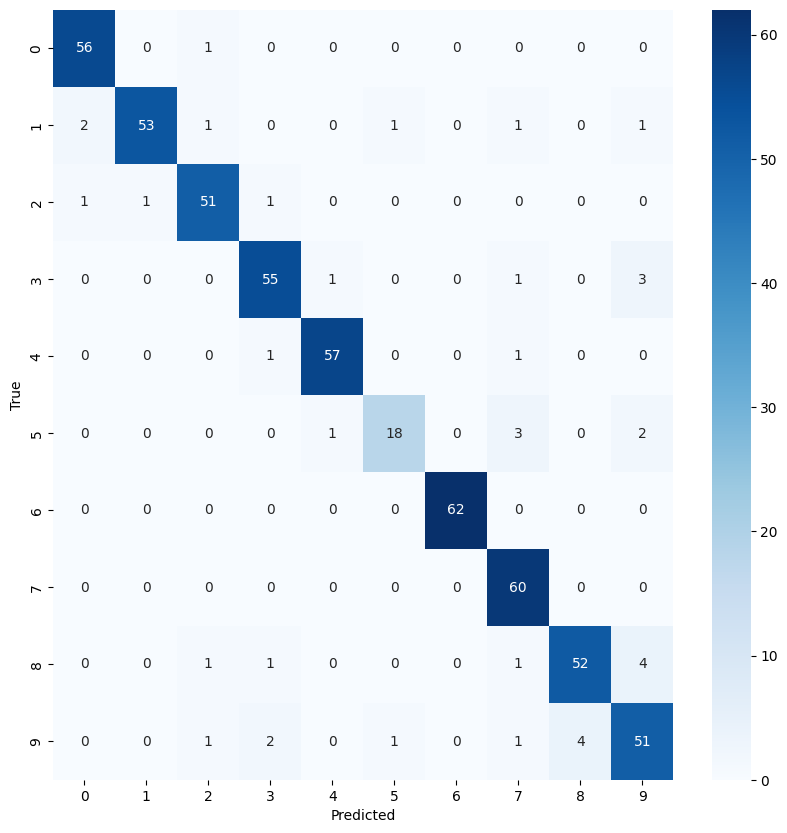

In [5]:
def plot_confusion_matrix(model, dataloader):
    model.eval()
    true_labels = []
    pred_labels = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(model, test_dataloader)